# Intro
This is a PyTorch Tutorial for ECE1512- Digital Image Processing and Applications (Winter 2021).
There's already a bunch of great tutorials that you might want to check out, and in particular [this tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).
This tutorial covers a lot of the same material. If you're familiar with PyTorch basics, you might want to skip ahead to the PyTorch Advanced section.

First, let's import some things and define a useful plotting function

In [ ]:
#@title imports and define `plot`
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot(xs, ys, xlim=(-3, 3), ylim=(-3, 3)):
  fig, ax = plt.subplots()
  ax.plot(xs, ys, linewidth=5)
  # ax.set_aspect('equal')
  ax.grid(True, which='both')
  
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
  ax.set_xlim(*xlim)
  ax.set_ylim(*ylim)

For GPU support, go to `Runtime > Change runtime type`.

# PyTorch Basic

## Tensors

Numpy arrays are objects that allow you to store and manipulation matrices.

In [ ]:
shape = (2, 3)
x = np.zeros(shape)
y = np.ones(shape)
z = x + y
print(x)
print("+")
print(y)
print("=")
print(z)

[[0. 0. 0.]
 [0. 0. 0.]]
+
[[1. 1. 1.]
 [1. 1. 1.]]
=
[[1. 1. 1.]
 [1. 1. 1.]]


In [ ]:
# print(z.sum())
print(z[0, 1:])

[1. 1.]


PyTorch is build around _tensors_, which play a similar role as numpy arrays. You can do many of the same operations in PyTorch:

In [ ]:
x = torch.zeros(shape)
y = torch.ones(shape)
z = x + y

print(x)
print("+")
print(y)
print("=")
print(z)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
+
tensor([[1., 1., 1.],
        [1., 1., 1.]])
=
tensor([[1., 1., 1.],
        [1., 1., 1.]])


Many functions have alternate syntax that accomplish the same thing

In [ ]:
torch.add(x, y)

In [ ]:
z.min()

In [ ]:
z[1:, 0]

In [ ]:
torch.sum(z)

Function that reduce dimenions will by default reduce all dimensions unless a dimension is specified

In [ ]:
torch.sum(z, dim=1)

In [ ]:
torch.sum(z, dim=0)

Like numpy, pytorch will try to broadcast operations

In [ ]:
x = torch.ones((3, 1))
y = torch.ones((1, 3))
z = x + y

print(x)
print("+")
print(y)
print("=")
print(z)

Operations that end with an underscore denote in-place functions. Use these sparingly as they easily lead to bugs.

In [ ]:
print(z)
z.zero_()
print(z)

In [ ]:
z.add_(5)
print(z)

### Moving between numpy and PyTorch

In [ ]:
x_np = np.random.randn(*shape)
print(x_np)

numpy -> pytorch is easy

In [ ]:
x = torch.from_numpy(x_np)
print(x)

By default, numpy arrays are float64. You'll probably want to convert arrays to float32, as most tensors in pytorch are float32.

In [ ]:
x = torch.from_numpy(x_np).to(torch.float32)
print(x)

pytorch -> numpy is also easy

In [ ]:
print(x.numpy())

### GPU support

In [ ]:
torch.cuda.is_available()

The code below errors out because both tensors need to be on the same device.

In [ ]:
device = torch.device("cuda")
x = torch.zeros(shape)
y = torch.ones(shape, device=device)
z = x + y

You can move a tensor to the GPU by using the `to` function.

In [ ]:
x = x.to(device)
z = x + y
print(z)

This code also errors out, because you can't convert tensors on a GPU into numpy arrays directly.

In [ ]:
z.numpy()

First you need to move them to the CPU.

In [ ]:
z_cpu = z.to('cpu')
z_cpu.numpy()

## Neural-Network specific functions
PyTorch has a bunch of built-in funcitons.
See [the docs](https://pytorch.org/docs/stable/torch.html) for a full list.

In [ ]:
xs = torch.linspace(-3, 3, 100)
ys = torch.relu(xs)
plot(xs.numpy(), ys.numpy())

In [ ]:
xs = torch.linspace(-3, 3, 100)
ys = torch.tanh(xs)
plot(xs.numpy(), ys.numpy())

In [ ]:
xs = torch.linspace(-3, 3, 100)
ys = torch.selu(xs)
plot(xs.numpy(), ys.numpy())

## Automatic differentiation

Given some loss function
$$L(\vec x, \vec y) = ||2 \vec x + \vec y||_2^2$$
we want to evaluate
$$\frac{\partial L}{\partial \vec x}$$
and
$$\frac{\partial L}{\partial \vec y}$$

In [ ]:
shape = (3, )
x = torch.tensor([1., 2, 3], requires_grad=True)
y = torch.ones(shape, requires_grad=True)

PyTorch makes this easy by having tensors keep track of their data...

In [ ]:
x.data

...and their gradient:

In [ ]:
print(x.grad)

However, right now `x` has no gradient because it does not know what loss it must be differentiated with respect to.
Below, we define the loss.

In [ ]:
loss = ((2 * x + y)**2).sum()
print(loss)

And we perform back-propagation by calling `backward` on it.

In [ ]:
loss.backward()

Now we see that the gradients are populated!

In [ ]:
print(x.grad)
print(y.grad)

### gradients accumulate
Gradients accumulate, os if you call backwards twice...

In [ ]:
loss = ((2 * x + y)**2).sum()
loss.backward()

...you'll get twice the gradient.

In [ ]:
print(x.grad)
print(y.grad)

### multiple losses

This accumulation makes it easy to add gradients from different losses, which might not even use the same parameters. For example, this loss is only a function of `x`....

In [ ]:
other_loss = (x**2).sum()
other_loss.backward()

...and so only `x.grad` changes.

In [ ]:
print(x.grad)
print(y.grad)

### stopping and starting gradients

If you don't specify `required_grad=True`, the gradient will always be `None`.

In [ ]:
shape = (3, )
x = torch.tensor([1., 2, 3], requires_grad=True)
y = torch.ones(shape)
loss = ((2 * x + y)**2).sum()
loss.backward()
print(x.grad)
print(y.grad)

tensor([12., 20., 28.])
None


You can turn `required_grad` back on after initializing a tensor.

In [ ]:
shape = (3, )
x = torch.tensor([1., 2, 3], requires_grad=True)
y = torch.ones(shape)
y.requires_grad = True
loss = ((2 * x + y)**2).sum()
loss.backward()
print(x.grad)
print(y.grad)

You can cut a gradient by calling `y.detach()`, which will return a new tensor with `required_grad=False`. Note that `detach` is not an in-place operation!

In [ ]:
shape = (3, )
x = torch.tensor([1., 2, 3], requires_grad=True)
y = torch.ones(shape, requires_grad=True)
# y_detached = y.detach()
loss = ((2 * x + y)**2).sum()
loss.backward()
print(x.grad)
print(y.grad)

tensor([12., 20., 28.])
tensor([ 6., 10., 14.])


In [ ]:
shape = (3, )
x = torch.tensor([1., 2, 3], requires_grad=True)
y = torch.ones(shape, requires_grad=True)
z = 2 * x
z.required_grad = True
loss = ((2 * z + y)**2).sum()
loss.backward()
print(x.grad)
print(y.grad)

tensor([ 40.,  72., 104.])
tensor([10., 18., 26.])


In [ ]:
z.grad

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  """Entry point for launching an IPython kernel.


In [ ]:
torch.from_numpy(np.array([1,2]))

tensor([1, 2])

Any difference between p.data.add_(-0.001 + p.grad) and p.data+= -0.001 + p.grad?

## Modules
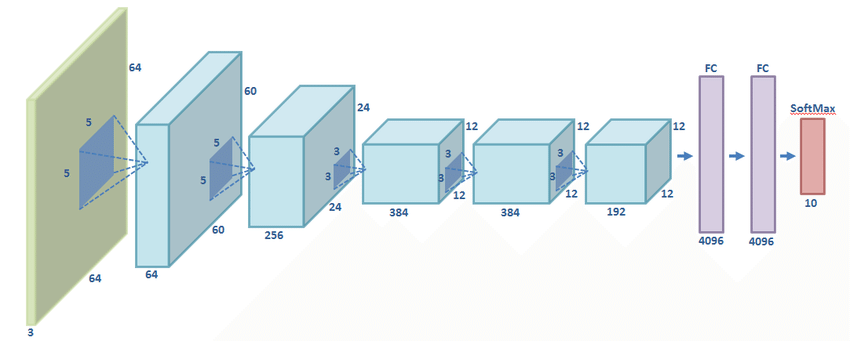

`nn.Modules` represent the building blocks of a computation graph.
For example, in typical pytorch code, each convolution block above is its own module, each fully connected block is a module, and the whole network itself is also a module.
Modules can contain modules within them.
All the classes inside of `torch.nn` are instances `nn.Modules`.
Below is an example definition of a module:

In [ ]:
import pdb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        pdb.set_trace()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def hook(self, gradient):
      return 2*gradient

The main function that you need to implement is the `forward` function.
Otherwise, it's a normal Python object:

In [ ]:
net = Net(input_size=1, output_size=1)
print(net)

Net(
  (fc1): Linear(in_features=1, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


Here we create some dummy input. The first dimension will be the batch dimension.

In [ ]:
x = torch.linspace(-5, 5, 100).view(100, 1)
print(x.shape)

torch.Size([100, 1])


To evaluate a neural network on some input, you pass an input through a module by calling it directly. In particular, don't call `net.forward(x)`.

In [ ]:
y = net(x)
print(y.shape)

> <ipython-input-37-7c9b43d6b070>(16)forward()
-> x = F.relu(self.fc1(x))
(Pdb) print(x)
tensor([[-5.0000],
        [-4.8990],
        [-4.7980],
        [-4.6970],
        [-4.5960],
        [-4.4949],
        [-4.3939],
        [-4.2929],
        [-4.1919],
        [-4.0909],
        [-3.9899],
        [-3.8889],
        [-3.7879],
        [-3.6869],
        [-3.5859],
        [-3.4848],
        [-3.3838],
        [-3.2828],
        [-3.1818],
        [-3.0808],
        [-2.9798],
        [-2.8788],
        [-2.7778],
        [-2.6768],
        [-2.5758],
        [-2.4747],
        [-2.3737],
        [-2.2727],
        [-2.1717],
        [-2.0707],
        [-1.9697],
        [-1.8687],
        [-1.7677],
        [-1.6667],
        [-1.5657],
        [-1.4646],
        [-1.3636],
        [-1.2626],
        [-1.1616],
        [-1.0606],
        [-0.9596],
        [-0.8586],
        [-0.7576],
        [-0.6566],
        [-0.5556],
        [-0.4545],
        [-0.3535],
        [-0.2525],

Let's visualize what the networks looks like.

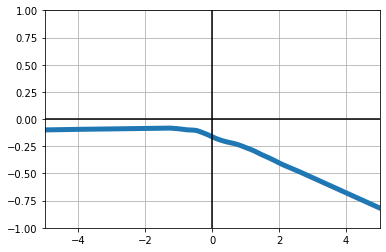

In [ ]:
plot(x.detach().numpy(), y.detach().numpy(), ylim=(-1, 1), xlim=(-5, 5))

The network keeps track of all the parameters and gradients!

In [ ]:
print(net.fc1.bias.grad)

In the `__init__` function, any variable that you assign to `self` that is also a module will be automatically added as a sub-module. The parameters of a module (and all sub-modules) can be accessed through the `parameters()` function:

In [ ]:
for p in net.parameters():
  print(p.shape)

torch.Size([32, 1])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


WARNING: if you want to have a list of modules use
```
def __init__(self, network1, network2):
  self.list = nn.ModuleList([network1, network 2])
```
and **not** 
```
def __init__(self, network1, network2):
  self.list = [network1, network 2]
```
In the later case, `network1` and `network2` won't be added as sub-modules.

The output of the module is just a tensor. We can perform operations on the tensor like before to automatically compute derivatives.
For example, below, we minimize the sum-of-squares of the output.

In [ ]:
loss = (y**2).sum()
loss.backward()

We can manually update the parameters by adding the gradient (times a negative learning rate) and zero'ing out the gradients to prevent gradient accumulation.

In [ ]:
for p in net.parameters():
  p.data.add_(-0.001 * p.grad)
  p.grad.data.zero_()

And we can do this in a loop to train our network!

In [ ]:
for _ in range(100):
  y = net(x)
  loss = (y**2).sum()
  loss.backward()
  for p in net.parameters():
    p.data.add_(- 0.001 * p.grad)
    p.grad.data.zero_()

Sure enough, our network learns to set everything to zero.

In [ ]:
plot(x.detach().numpy(), y.detach().numpy(), ylim=(-1, 1), xlim=(-5, 5))

## Loss Functions
PyTorch has a bunch of built in loss functions, which are just other modules that you can pass your data through.

In [ ]:
y_target = torch.sin(x)
loss_fn = nn.SmoothL1Loss()

In [ ]:
for _ in range(1000):
  y = net(x)
  loss = loss_fn(y, y_target)
  loss.backward()
  for p in net.parameters():
    p.data.add_(- 0.001 * p.grad)
    p.grad.data.zero_()

In [ ]:
plot(x.detach().numpy(), y.detach().numpy(), ylim=(-1, 1), xlim=(-5, 5))

## Optimizers

We can use more fancy optimizers with the `optim` package.

In [ ]:
from torch import optim

net = Net(input_size=1, output_size=1)

optimizer = optim.Adam(net.parameters(), lr=1e-3)

x = torch.linspace(-5, 5, 100).view(-1, 1)
y = net(x)
y_target = torch.sin(x)
loss_fn = nn.MSELoss()

Here's the network before training

In [ ]:
plot(x.detach().numpy(), y.detach().numpy(), ylim=(-1, 1), xlim=(-5, 5))

and here's how you can use the optimize to train the network.
Note that we call `zero_grad` _before_ calling `loss.backward()`, and then we just call `optimizer.step()`. This `step` function will take care of updating all the parameters that were passed to that optimizer's constructor.

In [ ]:
for _ in range(100):
  y = net(x)
  loss = loss_fn(y, y_target)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

And we see that this trained a network quite well

In [ ]:
plot(x.detach().numpy(), y.detach().numpy(), ylim=(-1, 1), xlim=(-5, 5))

## Regression example

We're going to train two separate neural networks to solve a prediction task:
$$f_\theta(x) \approx y$$
First we generate the data

In [ ]:
N = 100
d = 1
X = np.random.randn(N, 1)
Y = X * 2 + 3 + np.random.randn(N, 1)
plt.scatter(X, Y)

In [ ]:
print(X.shape, Y.shape)

Next we convert that data to pytorch

In [ ]:
X_pt = torch.from_numpy(X).to(torch.float32)
Y_pt = torch.from_numpy(Y).to(torch.float32)

loss_fn = nn.MSELoss()

Define the training loop

In [ ]:
def train(net: nn.Module):
  optimizer = optim.SGD(net.parameters(), lr=1e-2)
  losses = []
  for _  in range(100):
    Y_hat_pt = net(X_pt)
    loss = loss_fn(Y_hat_pt, Y_pt) 
  
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
    losses.append(loss.detach().numpy())
  return np.array(losses)

Let's test two different networks

In [ ]:
linear_network = nn.Linear(1, 1)
linear_losses = train(linear_network)

non_linear_network = Net(1, 1)
non_linear_losses = train(non_linear_network)

and plot the losses and predictions.

In [ ]:
plt.figure()
t = np.arange(len(linear_losses))
plt.plot(t, linear_losses, t, non_linear_losses)
plt.legend(['linear', 'non_linear'])

In [ ]:
x_probe = torch.linspace(X.min(), X.max(), 300).reshape(-1, 1)
y_lin = linear_network(x_probe).detach().numpy()
y_non_lin = non_linear_network(x_probe).detach().numpy()

plt.scatter(x_probe.numpy(), y_lin, s=3)
plt.scatter(x_probe.numpy(), y_non_lin, s=3)
plt.scatter(X, Y)
plt.legend(['linear', 'non_linear', 'data'])

# PyTorch - Advanced

## Distributions
PyTorch has a very convenient [distributions](https://pytorch.org/docs/stable/distributions.html) package.

In [ ]:
from torch import distributions

You create distributions by passing the parameters of the distribution.

In [ ]:
mean = torch.zeros(1, requires_grad=True)
std = torch.ones(1, requires_grad=True)
gaussian = distributions.Normal(mean, std)

These distributions are instances of the more general `Distribution` class, which you can read more about [here](https://pytorch.org/docs/stable/distributions.html#distribution).

In [ ]:
print(gaussian)
print(isinstance(gaussian, distributions.Distribution))

In [ ]:
sample = gaussian.sample((1,))
print(sample)

In [ ]:
gaussian.log_prob(sample)

In [ ]:
loss = - gaussian.log_prob(sample).sum()

In [ ]:
loss.backward()

In [ ]:
mean.grad

## Batch-Wise distribution

The distributions also support batch-operations. In this case, all the operations (`sample`, `log_prob`, etc.) are batch-wise.

In [ ]:
mean = torch.zeros(10)
std = torch.ones(10)
gaussian = distributions.Normal(mean, std)

In [ ]:
gaussian

In [ ]:
sample = gaussian.sample((1,))
print(sample)

In [ ]:
gaussian.log_prob(sample)

## Multivariate Normal

There are other distributions

In [ ]:
mean = torch.zeros(2)
covariance = torch.tensor(
    [[1, 0.8],
     [0.8, 1]]
)
gaussian = distributions.MultivariateNormal(mean, covariance)

In [ ]:
gaussian.sample((1,))

In [ ]:
samples = gaussian.sample((500,))
plt.scatter(samples[:, 0].numpy(), samples[:, 1].numpy())

NOTE: if you want to use a batch of `MultivariateNormal` distributions, you'll need to construct a batch of covariance matrices (i.e. shape `[BATCH_SIZE, DIM, DIM]`).

## Categorical Distribution

In [ ]:
from torch import distributions

Another useful distribution is the categorical distribution.

In [ ]:
probs = torch.tensor([0.1, 0.2, 0.7])
dist = distributions.Categorical(probs=probs)

In [ ]:
sample = dist.sample([20])
print(sample)

In [ ]:
dist.log_prob(sample)

## Distributions and Modules

Typically, your network will output parameters of a distribution

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
mean_network = Net(1, 1)
x = torch.randn(100, 1)
mean = mean_network(x)
distribution = distributions.Normal(x, scale=1)

If you want, your nn.Module can return a distribution in the `forward` function!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return distributions.Normal(x, scale=1)

In [ ]:
distribution_network = Net(1, 1)
x = torch.randn(100, 1)
distribution = distribution_network(x)